In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import MeCab
import re
import collections
import random
from scipy.special import gamma, digamma, gammaln
from scipy.stats import dirichlet, multinomial
from IPython.core.pylabtools import figsize
%matplotlib inline

# MLP本 「トピックモデル」の実装＋実験＋式導出

「トピックモデル」本の中で紹介されている
* 最尤推定
* 変分ベイズ
* 崩壊型ギブスサンプリング
* 階層ディリクレ過程

の実装, 実験, 式の導出がしてあります.
使用データはwikipediaのデータです.

In [0]:
#wikipediaのデータから単語を抜き出す前処理処理

reg = r'".+"' 
reg_id = r'id=".*?"' # .*? は0個以上の任意の文字の最小一致という意味
reg_title = r'title=".*?"'
search_num = r"\d+"

pattern = re.compile(reg) #事前にコンパイルしておくと動作が早くなる
p1 = re.compile(reg_id)
p2 = re.compile(reg_title)
p3 = re.compile(search_num)

def to_id_title(words):
    ids = p1.search(words).group() #id=" "の部分を抜き出し
    title = p2.search(words).group() #title=" "の部分を抜き出し
    ids = pattern.search(ids).group()[1:-1] #id=" "から" "の中身を抜き出し
    title = pattern.search(title).group()[1:-1] #title=" "から" "の中身を抜き出し
    return (ids, title)

def to_wordlist(words):
    m = MeCab.Tagger ("-Ochasen")
    word_list = [] #抜き出した名詞リスト

    #不要語リスト
    remove_words = ["(", ")", "（", "）", "[", "]",
                    "「", "」", "+", "-", "*", "$",
                    "'", '"', "、", ".", "”", "’",
                    ":", ";", "_", "/", "?", "？", 
                    "!", "！", "。", ",", "%", "％",
                    "=", "＝", "&", "・"]
    
    with open("stop_word.txt", "r", encoding="utf-8") as f:
        stop_words = f.read().split() #ストップワード
    
    remove_words += stop_words
    remove_words += [n for n in "abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ"]
    remove_words = set(remove_words)
    
    #分かち書きして分割された語を順にループ
    for chunk in m.parse(words.rstrip()).splitlines()[:-1]:
        word = chunk.rstrip().split('\t')[2] #分かち書きされた語
        tok = chunk.rstrip().split('\t')[3] #上の語の品詞

        #もしtokが名詞かつ不要語や数字が含まれていなかったらhukugouに追加
        if tok.startswith("名詞"):
            if not word in remove_words and re.search(p3, word) is None:
                word_list.append(word)
            
    return word_list

def make_kizi(word_num):
    kizi_dict = {} #{title: [words]}
    all_word = [] #使用する記事に出てくる全単語
    with open("wiki100.txt", "r") as files:
        string = files.readline()
        kizi = title = ids = ""
        i = 0
        
        while string:
            if string.find('<doc') >= 0:
                ids, title = to_id_title(string)
            elif string.find('</doc>') >= 0:
                tmp = to_wordlist(kizi)
                if 300 < len(tmp) < 600: #適当な長さの記事を使用
                    print(i) #確認用
                    kizi_dict[title] = tmp
                    all_word += tmp
                kizi = ""
                print('number:%d title:%s id:%s' %(i, title, ids)) #確認用python2ならかっこを外してください。
                i += 1
            else:
                kizi = kizi + string.strip()
            
            string = files.readline()
    
    c = collections.Counter(all_word).most_common()
    word_list = [c[i][0] for i in range(word_num)]
    word_set = set(word_list)
    new_kizi_dict = {}
    
    for title, words in kizi_dict.items():
        tmp = [w for w in words if w in word_set]
        new_kizi_dict[title] = tmp
        
    return new_kizi_dict, word_list


#最尤推定
"""
word_dict : dict {title:[words]}
all_word : list
topic_num : トピック数
iteration : ループ数
"""
def plsa(word_dict, all_word, topic_num, iteration=300):
    word_num = len(all_word)
    theta = np.random.dirichlet(np.random.rand(topic_num)+1., len(word_dict)) #(記事数, トピック数)
    phi = np.random.dirichlet(np.random.rand(word_num)+1., topic_num) #(トピック数, 単語数)
    for i in range(iteration):
        print("i:%d" %i)
        theta_next = np.zeros(theta.shape)
        phi_next = np.zeros(phi.shape)
        L = 0
        for d, words in enumerate(word_dict.values()):
            for n in words:
                #_L = 0
                q = theta[d]*phi[:, all_word.index(n)]/np.dot(theta[d], phi[:,all_word.index(n)])
                theta_next[d] += q
                phi_next[:, all_word.index(n)] += q
                L += np.log(np.dot(theta[d], phi[:, all_word.index(n)]))
        theta = theta_next.copy()
        phi = phi_next.copy()
        theta /= theta.sum(axis=1).reshape(theta.shape[0],1)
        phi /= phi.sum(axis=1).reshape(phi.shape[0],1)
        print("likelihood:%d" %L)
    return theta, phi


#変分ベイズ
"""
word_dict : dict {title:[words]}
all_word : list
topic_num : トピック数
iteration : ループ数
"""
def vbe(word_dict, all_word, topic_num, iteration=300):
    word_num = len(all_word)
    alpha = np.random.rand(len(word_dict), topic_num)+1.0 #(記事数, トピック数)
    beta = np.random.rand(topic_num, word_num)+1.0 #(トピック数, 単語数)
    beta_next = beta.copy()
    theta = np.random.dirichlet(np.random.rand(topic_num)+1.0, len(word_dict)) #(記事数, トピック数)
    phi = np.random.dirichlet(np.random.rand(word_num)+1.0, topic_num) #(トピック数, 単語数)
    for i in range(iteration):
        print("i:%d" %i)
        q = digamma(alpha) - digamma(alpha.sum(axis=1)).reshape(alpha.shape[0],1) - \
            digamma(beta.sum(axis=1))
        L = 0
        for d, words in enumerate(word_dict.values()):
            for n in words:
                ind = all_word.index(n)
                q_ = np.exp(q[d] + digamma(beta[:, ind]))
                q_ /= q_.sum()
                alpha[d] += q_
                beta_next[:, ind] += q_
                L += np.log(np.dot(theta[d], phi[:, ind]))
            
        print("likelihood:%d" %L)
        #print(beta[0])
        beta = beta_next.copy()
        for j in range(theta.shape[0]):
            theta[j] = dirichlet.rvs(alpha[j], 1)
        for m in range(phi.shape[0]):
            phi[m] = dirichlet.rvs(beta[m], 1)
            
    #return alpha, beta
    return theta, phi


#崩壊型ギブスサンプリング
"""
word_dict : dict {title:[words]}
all_word : list
topic_num : トピック数
iteration : ループ数
"""
def gibbs(word_dict, all_word, topic_num, iteration=300):
    word_num = len(all_word)
    dict_len = len(word_dict)
    alpha = np.random.rand(topic_num)+1.0 #(トピック数)
    beta = 1. 
    N_dk = np.zeros((dict_len, topic_num), dtype=np.int) #文書dでトピックkが割り当てられた単語数
    N_kv = np.zeros((topic_num, word_num), dtype=np.int) #文書全体でトピックkが割り当てられた単語vの数
    N_k = np.zeros(topic_num, dtype=np.int) #文書全体でトピックkが割り当てられた回数
    N_d = np.zeros(dict_len, dtype=np.int) #文書dの単語数
    z_dn = [] #文書dのn番目の単語に割り当てられたトピック
    for i in range(iteration):
        print("i:%d" %i)
        for d, words in enumerate(word_dict.values()):
            if i == 0:
                N_d[d] = len(words)
                z_dn.append([None for j in range(len(words))])
            for j, n in enumerate(words):
                ind = all_word.index(n)
                if i > 0:
                    N_dk[d][z_dn[d][j]] -= 1
                    N_kv[z_dn[d][j]][ind] -= 1
                    N_k[z_dn[d][j]] -= 1
                p = (N_dk[d] + alpha)*((N_kv[:, ind] + beta)/(N_k[:] + beta*word_num))
                p /= p.sum()
                z = int(np.where(multinomial.rvs(1, p) == 1)[0])
                z_dn[d][j] = z
                N_dk[d][z] += 1
                N_kv[z][ind] += 1
                N_k[z] += 1
                
        alpha *= (digamma(N_dk + alpha).sum(axis=0) - dict_len*digamma(alpha)) / \
                 (digamma(N_d + alpha.sum()).sum() - dict_len*digamma(alpha.sum()))
        beta  *= (digamma(N_kv + beta).sum() - topic_num*word_num*digamma(beta)) / \
                 (word_num*digamma(N_k + beta*word_num).sum() - topic_num*word_num*digamma(beta*word_num))
        
        L = dict_len*(gammaln(alpha.sum()) - gammaln(alpha).sum()) + \
            gammaln(N_dk + alpha).sum() - gammaln(N_d + alpha.sum()).sum() + \
            topic_num*(gammaln(beta*word_num) - word_num*gammaln(beta)) + \
            gammaln(N_kv + beta).sum() - gammaln(N_k + beta*word_num).sum()
            
        print("likelihood:%d" %L)
        
    theta = (N_dk + alpha) / np.c_[(N_d + alpha.sum())]
    phi = (N_kv + beta) / np.c_[(N_k + beta*word_num)]
    
    return theta, phi


#階層ディリクレ過程
"""
word_dict : dict {title:[words]}
all_word : list
topic_num : トピック数
alpha, gamma, beta : ハイパーパラメータ
iteration : ループ数
"""
def HDP_LDA(word_dict, all_word, alpha=1.0, gamma=1.0, beta=1.0, iteration=300):
    word_dict, test_dict = make_tastdata(word_dict)
    dict_len = len(word_dict) 
    word_num = len(all_word)
    N_dk = np.empty((dict_len, 0), dtype=np.int) #文書dでトピックkが割り当てられた単語数
    N_kv = np.empty((0, word_num), dtype=np.int) #文書全体でトピックkが割り当てられた単語vの数
    N_k = np.empty(0, dtype=np.int) #文書全体でトピックkが割り当てられた回数
    N_d = np.zeros(dict_len, dtype=np.int) #文書dの単語数
    N_dlv = [np.empty((0, word_num), dtype=np.int) for i in range(dict_len)]#文書dでL番目のテーブルに割り当てられた単語vの数
    t_dn = [] #文書dのn番目の単語に割り当てられたテーブル
    z_dl = [[] for j in range(dict_len)] #文書dのL番目のテーブルに割り当てられたトピック
    z_dn = [] #文書dのn番目の単語に割り当てられたトピック
    M_k = np.empty(0, dtype=np.int) #トピックkを選んだテーブル数
    #N_dl = None #文書dでL番目のテーブルを選んだ単語数(N_dlvで兼用できる)
    #M = None #テーブル数(M_kで兼用できる)
    L_list = []
    perp_list = []
    topicnum_list = []
    tablenum_list = []
    
    for i in range(iteration):
        print("i:%d" %i)
        for d, words in enumerate(word_dict.values()):
            if d % 500 == 0:
                print("d:%d" %d)
            if i == 0:
                N_d[d] = len(words)
                tmp = [-1 for j in range(N_d[d])]
                z_dn.append(np.array(tmp, dtype=np.int))
                t_dn.append(np.array(tmp, dtype=np.int))
        
            for j, n in enumerate(words): 
                ind = all_word.index(n)
                if i > 0:
                    N_dk[d][z_dn[d][j]] -= 1
                    N_kv[z_dn[d][j]][ind] -= 1
                    N_k[z_dn[d][j]] -= 1
                    N_dlv[d][t_dn[d][j]][ind] -= 1
                    if N_dlv[d][t_dn[d][j]].sum() == 0: #文書dでテーブルLに座る人がいなくなったら
                        N_dlv[d] = np.delete(N_dlv[d], t_dn[d][j], axis=0)
                        M_k[z_dn[d][j]] -= 1
                        del z_dl[d][t_dn[d][j]]
                        t_dn[d][t_dn[d] > t_dn[d][j]] -= 1 #インデックスずらし
                        if N_k[z_dn[d][j]] == 0:
                            #文書dでテーブルLに座る人がいなくなった事によってトピックkの割り当てが0になったら
                            #print("a")
                            N_dk = np.delete(N_dk, z_dn[d][j], axis=1)
                            N_kv = np.delete(N_kv, z_dn[d][j], axis=0)
                            N_k = np.delete(N_k, z_dn[d][j])
                            M_k = np.delete(M_k, z_dn[d][j]) 
                            for x in z_dn:#インデックスずらし
                                x[x > z_dn[d][j]] -= 1
                            for xn, x in enumerate(z_dl):#インデックスずらし
                                z_dl[xn] = [y-1 if y>z_dn[d][j] else y for y in x]

                exist_t = np.array([])
                exist_t_len = 0
                new_t_E = np.array([]) 
                new_t_E_len = 0 
                if i != 0 or d != 0 or j != 0 :
                    new_t_E = (alpha*M_k/(M_k.sum()+gamma))*(N_kv[:, ind] + beta)/(N_k + beta*word_num)
                    new_t_E_len = len(new_t_E)
                    if i != 0 or j != 0 :
                        exist_t = N_dlv[d].sum(axis=1)*(N_kv[:, ind][z_dl[d]] + beta)/(N_k[z_dl[d]] + beta*word_num)
                        exist_t_len = len(exist_t)
                new_t_N = alpha*(gamma/(M_k.sum()+gamma))/word_num
                p_td = np.hstack((exist_t, new_t_E, new_t_N))
                p_td_len = len(p_td)
                #p_td = p_td.astype(float)
                p_td = p_td / p_td.sum() #- 0.00001/p_td.size
                z = int(np.where(multinomial.rvs(1, p_td) == 1)[0])
                if z == p_td_len-1: #新テーブル新トピック   
                    N_dk = np.append(N_dk, np.zeros((dict_len, 1), dtype=np.int) ,axis=1)
                    N_kv = np.append(N_kv, np.zeros((1, word_num), dtype=np.int), axis=0)
                    N_dlv[d] = np.append(N_dlv[d], np.zeros((1, word_num), dtype=np.int), axis=0)
                    N_k = np.append(N_k, 1)
                    M_k = np.append(M_k, 1)
                    new_topic = len(M_k)-1 
                    N_dk[d][new_topic] = 1
                    N_kv[new_topic][ind] = 1
                    N_dlv[d][exist_t_len][ind] = 1
                    z_dn[d][j] = new_topic
                    t_dn[d][j] = exist_t_len
                    z_dl[d].append(new_topic)
                elif exist_t_len <= z : #新テーブル既存トピック
                    N_dlv[d] = np.append(N_dlv[d], np.zeros((1, word_num), dtype=np.int), axis=0) #文書dでL番目のテーブルに割り当てられた単語vの数
                    z -= exist_t_len
                    N_dk[d][z] += 1
                    N_kv[z][ind] += 1
                    N_dlv[d][exist_t_len][ind] += 1
                    N_k[z] += 1
                    M_k[z] += 1
                    z_dn[d][j] = z
                    t_dn[d][j] = exist_t_len
                    z_dl[d].append(z)
                else: #既存テーブル
                    N_dk[d][z_dl[d][z]] += 1
                    N_kv[z_dl[d][z]][ind] += 1
                    N_k[z_dl[d][z]] += 1
                    N_dlv[d][z][ind] += 1
                    t_dn[d][j] = z
                    z_dn[d][j] = z_dl[d][z]
                    
            for l in range(len(z_dl[d])): #k = z_dl[d][l]
                N_dl_sum = N_dlv[d][l].sum() 
                N_dk[d][z_dl[d][l]] -= N_dl_sum #文書dでトピックkが割り当てられた単語数
                N_kv[z_dl[d][l]] -= N_dlv[d][l] #文書全体でトピックkが割り当てられた単語vの数
                N_k[z_dl[d][l]] -= N_dl_sum#文書全体でトピックkが割り当てられた回数
                M_k[z_dl[d][l]] -= 1 #トピックkを選んだテーブル数
                if M_k[z_dl[d][l]] == 0:
                    N_dk = np.delete(N_dk, z_dl[d][l], axis=1)
                    N_kv = np.delete(N_kv, z_dl[d][l], axis=0)
                    N_k = np.delete(N_k, z_dl[d][l])
                    M_k = np.delete(M_k, z_dl[d][l])
                    for x in z_dn:#インデックスずらし
                        x[x > z_dl[d][l]] -= 1
                    for xn, x in enumerate(z_dl):#インデックスずらし
                        z_dl[xn] = [y-1 if y>z_dl[d][l] else y for y in x]
                    
                old_topic = np.log(M_k)+gammaln(N_k+beta*word_num)-gammaln(N_k+N_dl_sum+beta*word_num)+\
                             np.sum(gammaln(N_kv+N_dlv[d][l]+beta)-gammaln(N_kv+beta), axis=1)
                new_topic = np.log(gamma)+gammaln(beta*word_num) - gammaln(N_dl_sum+beta*word_num)+\
                             np.sum(gammaln(N_dlv[d][l]+beta)) - word_num*gammaln(beta)
                p_zd = np.hstack((old_topic, new_topic))
                p_zd -= p_zd.mean()
                p_zd = np.exp(p_zd)
                p_zd = p_zd / p_zd.sum() #- 0.00001/p_zd.size
                z = int(np.where(multinomial.rvs(1, p_zd) == 1)[0])
                if z == len(p_zd) - 1:
                    N_dk = np.append(N_dk, np.zeros((dict_len, 1), dtype=np.int) ,axis=1)
                    N_kv = np.append(N_kv, np.zeros((1, word_num), dtype=np.int), axis=0)
                    N_k = np.append(N_k, N_dl_sum)
                    M_k = np.append(M_k, 1)
                    N_dk[d][len(M_k)-1] = N_dl_sum 
                    N_kv[len(M_k)-1] = N_dlv[d][l]
                    z_dl[d][l] = len(M_k)-1 #文書dのテーブルに割り当てられたトピック
                    z_dn[d][t_dn[d] == l] = z_dl[d][l]#文書dのn番目の単語に割り当てられたトピック
                else:
                    N_dk[d][z] += N_dl_sum
                    N_kv[z] += N_dlv[d][l]
                    z_dl[d][l] =  z
                    z_dn[d][t_dn[d] == l] = z
                    N_k[z] += N_dl_sum
                    M_k[z] += 1
        
        theta = (N_dk + alpha*M_k/(M_k.sum()+gamma))/np.c_[(N_d + alpha)]
        theta = np.append(theta, alpha*gamma/(M_k.sum()+gamma)/np.c_[(N_d + alpha)], axis=1)
        phi = (N_kv + beta) / np.c_[(N_k + beta*word_num)]
        phi = np.append(phi, np.full((1, word_num), 1/word_num), axis=0)
        
        L = likelihood(theta, phi, word_dict, all_word)
        perp = likelihood(theta, phi, test_dict, all_word, calc="P")
        L_list.append(L)
        perp_list.append(perp)
        topicnum_list.append(len(M_k))
        tablenum_list.append(M_k.sum())
        
        print("topic_num:%d" %len(M_k))
        print("table_num:%d" %M_k.sum())
        print("likelihood:%f" %L)
        print("perplexity:%f" %perp)
    
    theta = (N_dk + alpha)/np.c_[(N_d + alpha)]
    phi = np.delete(phi, phi.shape[0]-1, axis=0)
    return theta, phi, L_list,  perp_list, topicnum_list, tablenum_list

def make_tastdata(word_dict):
    train_dict = {}
    test_dict = {}
    for title, word in word_dict.items():
        random.shuffle(word)
        test_word = []
        for i in range(len(word)//10):
            test_word.append(word.pop())
        train_dict[title] = word
        test_dict[title] = test_word
    return train_dict, test_dict

#尤度
def likelihood(theta, phi, word_dict, all_word, calc="L"): #calc="L":likelihood,  "P":perplexity
    L = 0
    N_d_test = 0
    for d, words in enumerate(word_dict.values()):
        N_d_test += len(words)
        for j, n in enumerate(words): 
            ind = all_word.index(n)
            L += np.log((theta[d] * phi[:, ind]).sum())
    if calc == "L":
        return L
    else:
        return np.exp(-L/N_d_test)


In [ ]:
#データの前処理

word_num = 600 #使用する単語数
kizis, words = make_kizi(word_num)
print(len(kizis))

In [ ]:
#最尤推定の実験
topic_num = 30 #トピックの数
theta, phi = plsa(kizis, words, topic_num)

In [0]:
#簡易な最尤推定で得られた結果の可視化
#各トピックごとで出やすい単語を大きい順に10個列挙

sorted_phi = np.argsort(phi)
for i in range(topic_num):
    print("トピック%d：" %i, end="")
    for j in range(1,10):
        print(words[sorted_phi[i][-j]], end=", ")
    print()

トピック0：通信, カード, 信号, 方式, 回路, 電話, 規格, デジタル, 電流, 
トピック1：権, 条, 規定, 著作, 法律, 制, 選挙, 行政, 制度, 
トピック2：種, 生物, 動物, 細胞, 分類, 植物, 科, 系統, 種類, 
トピック3：活動, 日本, 社会, 意味, 天皇, 文化, 言葉, 近代, 歴史, 
トピック4：アメリカ, 国家, 軍, 世紀, フランス, イギリス, 州, 戦争, 世, 
トピック5：人間, 世界, 存在, 本, 地球, 光, 宇宙, 能力, 否定, 
トピック6：集合, formula, 群, 定理, 定義, 証明, "), 素数, 任意, 
トピック7：語, 文字, 言語, 表記, 意味, 英語, 日本語, 記号, 音, 
トピック8：作品, 映画, 漫画, 連載, アニメ, 賞, 小説, 出版, テレビ, 
トピック9：東京, 発行, 平均, 銀, 券, 両, 乗車, 率, 期間, 
トピック10：神, 説, 仏教, 派, 教, 仏, 経, インド, 世紀, 
トピック11：構造, 研究, 情報, 国際, 分野, 機械, 技術, 機関, 構成, 
トピック12：開発, 会社, 経済, 日本, 事業, 企業, 販売, 社, サービス, 
トピック13：機, 号, 開発, 暦, 戦車, 衛星, 型, 軌道, 使用, 
トピック14：施設, 空港, 航空, 建設, 建築, 番, 局, 側, 計画, 
トピック15：学, 研究, 理論, 数学, 科学, 哲学, 学者, 主義, 幾何, 
トピック16：駅, ホーム, 改札, JR, 設置, バス, 番線, 方面, 乗車, 
トピック17：使用, 日本, 型, 一般, 利用, 色, 必要, 現在, 物, 
トピック18：駅, 鉄道, 列車, 運転, 路線, 車両, 大阪, 運行, 車, 
トピック19：機能, コンピュータ, データ, ソフトウェア, コード, 処理, 開発, システム, 利用, 
トピック20：値, 単位, 関数, 空間, formula, 行列, 量, 定義, 計算, 
トピック21：電子, エネルギー, 原子, 物質, 分子, 反応, 物, 化学, 元素, 
トピック22：馬, 賞, 競走, 競馬, 労働, 料理, 日本, 地方, 国際, 
ト

In [ ]:
#変分ベイズの実験

alpha, beta = vbe(kizis, words, topic_num)

In [0]:
# 簡易な変分ベイズで得られた結果の可視化
#各トピックごとで出やすい単語を大きい順に10個列挙

phi2 = np.zeros(beta.shape)
for m in range(phi2.shape[0]):
    phi2[m] = dirichlet.rvs(beta[m], 1)
    
sorted_phi2 = np.argsort(phi2)
for i in range(topic_num):
    print("トピック%d：" %i, end="")
    for j in range(1,10):
        print(words[sorted_phi2[i][-j]], end=", ")
    print()

トピック0
駅
東京
路線
語
鉄道
昭和
列車
時代
平成
トピック1
文字
定義
コード
一般
研究
拡張
システム
出版
座標
トピック2
駅
電子
ホーム
設置
状態
使用
日本
バス
利用
トピック3
駅
言語
ホーム
島
現在
派
使用
朝
接続
トピック4
日本
存在
神
情報
ゲーム
利用
宗教
可能
燃料
トピック5
集合
社会
語
学
放送
formula
部分
存在
現在
トピック6
日本
映画
賞
馬
formula
種
生物
競馬
競走
トピック7
漫画
作品
連載
語
意味
少年
方程式
週刊
掲載
トピック8
音楽
世界
大学
作品
研究
科
年代
映画
戦争
トピック9
機
電気
行列
発電
電荷
単位
存在
現在
開発


In [ ]:
#崩壊型ギブスサンプリングの実験

theta3, phi3 = gibbs(kizis, words, topic_num)

In [0]:
#崩壊型ギブスサンプリングで得られた結果
#各トピックごとで出やすい単語を大きい順に10個列挙

sorted_phi3 = np.argsort(phi3)
topic_list = []
for i in range(topic_num):
    tmp = []
    for j in range(1,11):
        tmp.append(words[sorted_phi3[i][-j]])
    topic_list.append(tmp)

frame = pd.DataFrame(topic_list, index=["topic%d" %k for k in range(topic_num)])
frame

,0,1,2,3,4,5,6,7,8,9
topic0,駅,列車,鉄道,ホーム,路線,JR,バス,東京,設置,運転
topic1,formula,関数,集合,定義,計算,空間,x,方程式,演算,値
topic2,神,仏教,説,教,仏,宗教,ギリシア,思想,意味,世界
topic3,氏,郡,徳川,藩,時代,明治,江戸,代,石,現在
topic4,条,権,規定,法律,行政,著作,行為,項,制度,必要
topic5,音楽,放送,曲,演奏,番組,テレビ,出演,活動,作品,役
topic6,事業,日本,会社,サービス,企業,航空,営業,発行,業務,局
topic7,ゲーム,発売,版,シリーズ,ソフト,CD,カード,機,登場,販売
topic8,使用,型,機,開発,技術,利用,生産,製造,製品,日本
topic9,漫画,作品,連載,号,出版,少年,雑誌,週刊,掲載,アニメ


In [0]:
#各トピックである確率が一番大きい記事

sorted_theta3 = np.argsort(theta3, axis=0)
kizis_list = list(kizis.keys())
for i in range(theta3.shape[1]):
    print("topic%d %s" %(i, kizis_list[sorted_theta3[:, i][-3]]))

topic0 浅草橋駅
topic1 選択公理
topic2 部派仏教
topic3 越前国
topic4 行政上の強制執行
topic5 ラトルズ
topic6 個人旅行
topic7 ドラゴンクエストモンスターズ
topic8 ライン生産方式
topic9 うすた京介
topic10 イングマール・ベルイマン
topic11 ビスマス
topic12 物理単位
topic13 東北縦貫自動車道
topic14 WebDAV
topic15 マティルダ (神聖ローマ皇后)
topic16 スズキ亜目
topic17 臨床心理学
topic18 シリア文字
topic19 延長戦
topic20 西部戦線
topic21 線形合同法
topic22 国際連合総会
topic23 大人
topic24 海の日
topic25 帝王賞
topic26 近点・遠点
topic27 イオン化エネルギー
topic28 天皇の一覧
topic29 パルス変調


In [ ]:
#階層ディリクレ過程の実験

theta4, phi4, L_list, perp_list, topicnum_list, tablenum_list = HDP_LDA(kizis, words, alpha=1., gamma=2.)

In [0]:
#HDP-LDAで得られた結果
#各トピックごとで出やすい単語を大きい順に10個列挙

sorted_phi4 = np.argsort(phi4)
topic_list = []
pd.set_option('display.max_rows', 100)

for i in range(phi4.shape[0]):
    tmp = []
    for j in range(1,11):
        tmp.append(words[sorted_phi4[i][-j]])
    topic_list.append(tmp)

frame = pd.DataFrame(topic_list, index=["topic%d" %k for k in range(phi4.shape[0])])

frame

,0,1,2,3,4,5,6,7,8,9
topic0,作品,漫画,連載,版,賞,登場,日本,アニメ,シリーズ,発売
topic1,開発,機能,ゲーム,コンピュータ,可能,システム,データ,使用,コード,処理
topic2,研究,学,理論,科学,数学,構造,分野,大学,哲学,学者
topic3,単位,条,暦,規定,使用,定義,行政,温度,日本,法律
topic4,formula,集合,関数,定義,空間,行列,値,群,任意,ベクトル
topic5,神,仏教,語,時代,意味,説,王,日本,世,派
topic6,天皇,衛星,軌道,地球,宇宙,号,代,昭和,光,通信
topic7,時代,氏,郡,江戸,藩,明治,現在,徳川,代,中国
topic8,国家,日本,主義,社会,連合,国際,世界,制,活動,委員
topic9,値,信号,電圧,変換,波,電流,周波数,回路,平均,量


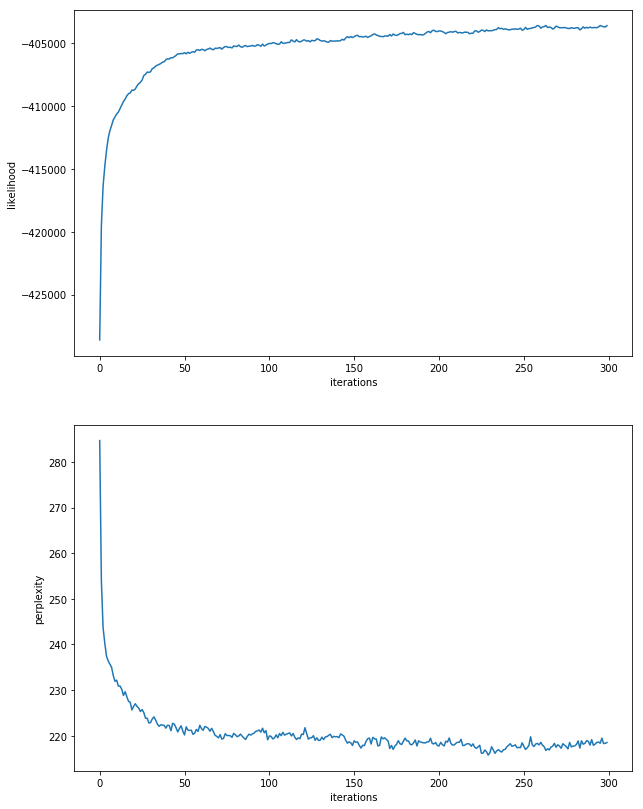

In [0]:
#尤度とperplexityのグラフ

figsize(10, 14)
plt.subplot(211)
plt.plot(L_list)
plt.xlabel("iterations")
plt.ylabel("likelihood")

plt.subplot(212)
plt.plot(perp_list)
plt.xlabel("iterations")
plt.ylabel("perplexity")
    
plt.savefig("HDP_LDA.png")

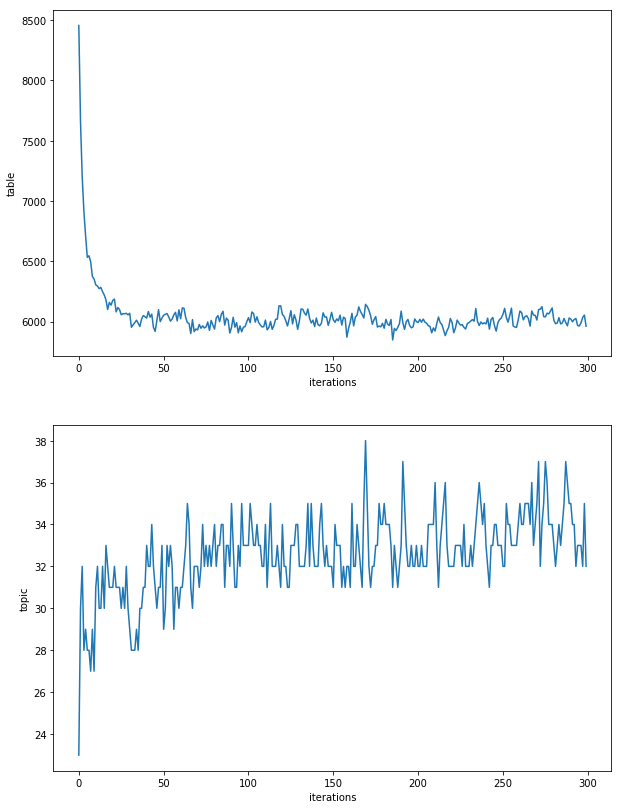

In [0]:
#階層ディリクレ過程におけるテーブルの数とトピック数

figsize(10, 14)
plt.subplot(211)
plt.plot(tablenum_list)
plt.xlabel("iterations")
plt.ylabel("table")

plt.subplot(212)
plt.plot(topicnum_list)
plt.xlabel("iterations")
plt.ylabel("topic")
    
plt.savefig("HDP_LDA_topic.png")

In [0]:
#各トピックである確率が一番大きい記事

sorted_theta4 = np.argsort(theta4, axis=0)
kizis_list = list(kizis.keys())
for i in range(theta4.shape[1]):
    print("topic%d %s" %(i, kizis_list[sorted_theta4[:, i][-1]]))

topic0 魔法少女アニメ
topic1 組み込みシステム
topic2 科学哲学
topic3 物理単位
topic4 逆元
topic5 メディア王国
topic6 舒明天皇
topic7 若狭国
topic8 都市国家
topic9 波
topic10 中野区
topic11 公用語
topic12 武蔵境駅
topic13 アングロアラブ
topic14 ミリタリーミニチュアシリーズ
topic15 核融合反応
topic16 教育課程
topic17 100
topic18 ユーフォニアム
topic19 フリーソフトウェア運動
topic20 能登空港
topic21 スーパーカミオカンデ
topic22 木村守男
topic23 電話
topic24 真核生物
topic25 記憶
topic26 フランス料理
topic27 普通乗車券
topic28 一分銀
topic29 カチンコ
topic30 経済
topic31 番勝負


## 最尤推定

EMアルゴリズムで対数尤度
$$L = \sum^{D}_{d=1}\sum^{N_{d}}_{n=1}\log\sum^{K}_{k=1}\theta_{dk}\phi_{k\omega_{dn}}$$
を最大にするパラメータ$\Theta$, $\Phi$を求める。

イェンゼンの不等式より

$$
L = \sum^{D}_{d=1}\sum^{N_{d}}_{n=1}log\sum^{K}_{k=1}q_{dnk}\frac{\theta_{dk}\phi_{k\omega_{dn}}}{q_{dnk}}\geq\sum^{D}_{d=1}\sum^{N_{d}}_{n=1}\sum^{K}_{k=1}q_{dnk}\log\theta_{dk}\phi_{k\omega_{dn}}-\sum^{D}_{d=1}\sum^{N_{d}}_{n=1}\sum^{K}_{k=1}q_{dnk}\log{q_{dnk}}\equiv F
$$

となるので、下限$F$を最大にしていく処理を繰り返すことにより推定が行える。

$q_{dnk}$の更新式は、ラグランジュの未定乗数法より

$$F(q_{dnk}) = q_{dnk}log\theta_{dk}\phi_{k\omega_{dn}} - q_{dnk}\log q_{dnk} - \lambda(\sum^{K}_{k=1}q_{dnk} - 1) $$
$$\frac{\partial F(q_{dnk})}{\partial q_{dnk}} = \log\theta_{dk}\phi_{k\omega_{dn}} - \log q_{dnk} - 1 - \lambda = 0 $$
$$q_{dnk} = \exp(-\lambda - 1)\theta_{dk}\phi_{k\omega_{dn}} \;\;\; (1)$$

両辺をk=1からKまで足し合わせると
$$1 = \exp(-\lambda - 1)\sum^{K}_{k=1}\theta_{dk}\phi_{k\omega_{dn}}$$
$$\exp(-\lambda - 1) = \frac{1}{\sum^{K}_{k=1}\theta_{dk}\phi_{k\omega_{dn}}}$$
(1)に代入すると
$$q_{dnk} = \frac{\theta_{dk}\phi_{k\omega_{dn}}}{\sum^{K}_{k^{\prime} =1}\theta_{dk^{\prime}}\phi_{k^{\prime} \omega_{dn}}}$$

同様にして、$\Theta$の更新式は、

$$
\begin{align}
\frac{\partial F(\theta_{dk})}{\partial \theta_{dk}} &= \frac{\sum^{N_{d}}_{n=1}q_{dnk}}{\theta_{dk}} - \lambda = 0 \\
\theta_{dk}\lambda &= \sum^{N_{d}}_{n=1}q_{dnk} \;\;\; (2)
\end{align}$$

両辺をk=1からKまで足し合わせると

$$\lambda = \sum^{K}_{k=1}\sum^{N_{d}}_{n=1}q_{dnk}$$

よって(2)に代入して整理すると

$$\theta_{dk} = \frac{\sum^{N_{d}}_{n=1}q_{dnk}}{\sum^{K}_{k^{\prime}=1}\sum^{N_{d}}_{n=1}q_{dnk^{\prime}}}$$

$\Phi$の更新式は、

$$\frac{\partial F(\phi_{kv})}{\partial \phi_{kv}} = \frac{\sum^{D}_{d=1}\sum_{n:w_{dn}=v}q_{dnk}}{\phi_{kv}} - \lambda = 0$$
$$\phi_{kv}\lambda = \sum^{D}_{d=1}\sum_{n:w_{dn}=v}q_{dnk} \;\;\; (3)$$

両辺をv=1からVまで足し合わせると

$$\lambda = \sum^{V}_{v=1}\sum^{D}_{d=1}\sum_{n:w_{dn}=v}q_{dnk}$$

よって(3)に代入して整理すると

$$\phi_{kv} = \frac{\sum^{D}_{d=1}\sum_{n:w_{dn}=v}q_{dnk}}{\sum^{V}_{v^{\prime}=1}\sum^{D}_{d=1}\sum_{n:w_{dn}=v^{\prime}}q_{dnk}}$$

## 変分ベイズ推定
対数周辺尤度

$$\log p(W|\boldsymbol{\alpha}, \boldsymbol{\beta}) = \log \iint\sum_{Z}p(W, Z, \Theta, \Phi | \boldsymbol{\alpha}, \boldsymbol{\beta})d\Theta d\Phi$$

イェンゼンの不等式より

$$
\begin{align}
F &= \iint\sum_{Z}q(Z, \Theta, \Phi) \log\frac{p(W, Z, \Theta, \Phi |\boldsymbol{\alpha}, \boldsymbol{\beta})}{q(Z, \Theta, \Phi)}d\Theta d\Phi \\
&= \iint\sum_{Z}q(Z)q(\Theta, \Phi)\bigl(\log p(Z|\Theta)p(\Theta|\boldsymbol{\alpha})p(W|Z,\Phi)p(\Phi|\boldsymbol{\beta}) - \log q(Z)q(\Theta, \Phi)\bigr)d\Theta d\Phi
\end{align}$$

対数周辺尤度と変分下限Fの差は、

$$\begin{align}
\log p(W|\boldsymbol{\alpha}, \boldsymbol{\beta}) - F &= \iint\sum_{Z}q(Z,\Theta, \Phi)\log p(W|\boldsymbol{\alpha}, \boldsymbol{\beta})d\Theta d\Phi - \iint\sum_{Z}q(Z, \Theta, \Phi) \log\frac{p(W, Z, \Theta, \Phi |\boldsymbol{\alpha}, \boldsymbol{\beta})}{q(Z, \Theta, \Phi)}d\Theta d\Phi \\
&= \iint\sum_{Z}q(Z,\Theta, \Phi)\log\frac{q(Z,\Theta, \Phi)}{p(Z, \Theta, \Phi |W,\boldsymbol{\alpha}, \boldsymbol{\beta})}d\Theta d\Phi \\
&= KL\bigl(q(Z,\Theta, \Phi),p(Z, \Theta, \Phi |W,\boldsymbol{\alpha}, \boldsymbol{\beta})\bigr)
\end{align}$$

より、変分下限を最大にする$q(Z,\Theta, \Phi)$は真の事後分布$p(Z, \Theta, \Phi |W, \boldsymbol{\alpha}, \boldsymbol{\beta})$とのKLダイバージェンスを最小にする。

ここで$q(Z,\Theta, \Phi) = q(Z)q(\Theta, \Phi)$と分解できると仮定する。

変分事後分布$q(Z)$の推定を考える。

$$F(q(Z)) = \iint\sum_{Z}q(Z)q(\Theta, \Phi) \bigl(\log p(W, Z, \Theta, \Phi |\boldsymbol{\alpha}, \boldsymbol{\beta}) - \log q(Z) - log q(\Theta, \Phi)\bigr)d\Theta d\Phi$$

$$\begin{align}
\frac{\partial F(q(Z))}{\partial q(Z)} &= \iint q(\Theta, \Phi) \bigl(\log p(W, Z, \Theta, \Phi |\boldsymbol{\alpha}, \boldsymbol{\beta}) - \log q(Z) - log q(\Theta, \Phi) - 1 \bigr)d\Theta d\Phi \\
&= E_{q(\Theta, \Phi)}[\log p(W, Z, \Theta, \Phi |\boldsymbol{\alpha}, \boldsymbol{\beta})] - \log q(Z) + const \;\;\; (1)
\end{align}$$

ここで$E_{q(x)}[f(x)] = \int q(x)f(x)dx$ は分布$q(x)$を用いた場合の$f(x)$の期待値を表す。

(1)を0にする$q(Z)$を解くと、

$$q(Z) \propto \exp(E_{q(\Theta, \Phi)}[\log p(W, Z, \Theta, \Phi | \boldsymbol{\alpha}, \boldsymbol{\beta})])$$

同様にして、

$$\frac{\partial F(q(\Theta, \Phi))}{\partial q(\Theta, \Phi)} = 0$$
より
$$q(\Theta, \Phi) \propto \exp(E_{q(Z)}[\log p(W, Z, \Theta, \Phi |\boldsymbol{\alpha}, \boldsymbol{\beta})])$$

$$p(W, Z, \Theta, \Phi |\boldsymbol{\alpha}, \boldsymbol{\beta}) = p(Z|\Theta)p(\Theta|\boldsymbol{\alpha})p(W|Z,\Phi)p(\Phi|\boldsymbol{\beta})$$

と分解でき、$\log p(\Theta|\boldsymbol{\alpha})$と$\log p(\Phi|\boldsymbol{\beta})$は$q(Z)$に関係しないので定数とみなせるので

$$\begin{align}
q(\Theta, \Phi) &\propto \exp \bigl(E_{q(Z)}[\log p(Z|\Theta)p(\Theta|\boldsymbol{\alpha})p(W|Z,\Phi)p(\Phi|\boldsymbol{\beta})]\bigr) \\
&= \exp \bigl(E_{q(Z)}[\log p(Z|\Theta)] + \log p(\Theta|\boldsymbol{\alpha}) \bigr) * \exp \bigl(E_{q(Z)}[\log p(W|Z,\Phi)] + \log p(\boldsymbol{\beta}) \bigr)
\end{align}$$

よって、パラメータの変分事後分布は

$$q(\Theta, \Phi) = q(\Theta)q(\Phi)$$

と分解できる。

$$\begin{align}
q(\theta_{d\cdot}) &\propto \exp\bigl(E_{q(z_{d\cdot})}[\log p(z_{d\cdot}|\theta_{d\cdot})] + \log p(\theta_{d\cdot}|\alpha_{d\cdot}) \bigr)\\
&= \exp\Bigl(E_{q(z_{d\cdot})}[\sum^{N_{d}}_{n=1}\log\theta_{dz_{n}}] + \log\frac{\Gamma(\sum^{K}_{k=1}\alpha_{dk})}{\prod^{K}_{k=1}\Gamma(\alpha_{dk})} + (maybe) \sum^{K}_{k=1}\log\theta^{\alpha_{dk}-1}_{dk}\Bigr)\\
&\propto \prod^{K}_{k=1}\theta^{\alpha_{dk}+\sum^{N_{d}}_{n=1}q_{d_{n}k}-1}_{dk}\\
&\propto Dirichlet(\theta_{d\cdot}|\alpha_{d1},\cdots, \alpha_{dk})
\end{align}$$

2段目では、$p(z_{d\cdot}|\theta_{d\cdot}) = \prod^{N_{d}}_{n=1}\theta_{dz_{n}}$であること、トピック分布$\theta_{d\cdot}$の事前分布がディリクレ分布であることを使用。
3段目では、$q_{d_{n}k}\equiv q(z_{d_{n}} = k)$を文書dのn番目の単語のトピック$z_{d_{n}}$が$k$になる変分事後分布とした時、$E_{q(z_{d\cdot})}[\sum^{N_{d}}_{n=1}\log\theta_{dz_{d_{n}}}] = \sum^{N_{d}}_{n=1}\sum^{K}_{k=1}q_{d_{n}k}\log\theta_{dk}$となる事、$\frac{\Gamma(\sum^{K}_{k=1}\alpha_{dk})}{\prod^{K}_{k=1}\Gamma(\alpha_{dk})}$は正規化項なので$\theta_{d\cdot}$に依存しないことを使用。

よって、$\theta_{1\cdot},\cdots,\theta_{D\cdot}$は独立であるので、

$$q(\Theta) = q(\theta_{1\cdot},\cdots,\theta_{D\cdot}) = \prod^{D}_{d=1}Dirichlet(\theta_{d\cdot}|\alpha_{d1},\cdots, \alpha_{dk})$$

が得られます。

また、$\alpha_{dk}$はディリクレ分布である変分事後分布$q(\theta_{d})$のパラメータ

$$\alpha_{dk} = \alpha_{dk} + \sum^{N_{d}}_{n=1}q_{d_{n}k}$$

となります。

同様の議論で単語分布の変分事後分布$q(\Phi)$は、

$$\begin{align}
q(\Phi) &\propto \exp \bigl(E_{q(Z)}[\log p(W|Z,\Phi)] + \log p(\Phi|\beta) \bigr)\\
&= \exp\Bigl(E_{q(Z)}[\sum^{D}_{d=1}\sum^{N_{d}}_{n=1}\log\phi_{z_{dn}w_{dn}}] + \sum^{K}_{k=1}\log\frac{\Gamma(\sum^{V}_{v=1}\beta_{kv})}{\prod^{V}_{v=1}\Gamma(\beta_{kv})} + \sum^{K}_{k=1}\sum^{V}_{v=1}\log\phi^{\beta_{kv}-1}_{kv}\Bigr)\\
&= \exp\Bigl(\sum^{K}_{k=1}\sum^{V}_{v=1}\sum^{D}_{d=1}\sum_{n:w_{dn}=v}q_{dnk}\log\phi_{kv} + \sum^{K}_{k=1}\log\frac{\Gamma(\sum^{V}_{v=1}\beta_{kv})}{\prod^{V}_{v=1}\Gamma(\beta_{kv})} + \sum^{K}_{k=1}\sum^{V}_{v=1}\log\phi^{\beta_{kv}-1}_{kv} \Bigr)\\
&\propto \exp\Bigl(\sum^{K}_{k=1}\sum^{V}_{v=1}\log\phi^{\beta_{kv} + \sum^{D}_{d=1}\sum_{n:w_{dn}=v}q_{dnk} -1}_{kv} \Bigr)\\
&\propto \prod^{K}_{k=1}Dirichlet(\phi_{k}|\beta_{k1},\cdots,\beta_{KV})
\end{align}$$

となる。$\sum_{n:w_{dn}=v}$は、文書dで単語vが出てくる全てのnについての和を表す。
また、$\beta_{kv}$は、

$$\beta_{kv} = \beta_{kv} + \sum^{D}_{d=1}\sum_{n:w_{dn}=v}q_{dnk}$$

となる。

トピック分布の変分事後分布は、

$$\begin{align}
p(Z) &\propto \exp\bigl(E_{q(\Theta,\Phi)}[\log p(Z|\Theta)p(\Theta|\alpha)p(W|Z,\Phi)p(\Phi|\beta)]\bigr)\\
&\propto \exp\bigl(E_{q(\Theta)}[\log p(Z|\Theta)] + E_{q(\Phi)}[\log p(W|Z,\Phi)]\bigr)\\
&= \exp\bigl(E_{q(\Theta)}[\sum^{D}_{d=1}\sum^{N_{d}}_{n=1}\log \theta_{dz_{dn}}] + E_{q(\Phi)}[\sum^{D}_{d=1}\sum^{N_{d}}_{n=1}\log\phi_{z_{dn}w_{dn}}]\bigr)\\
&= \prod^{D}_{d=1}\prod^{N_{d}}_{n=1}\exp\Bigl(\Psi(\alpha_{dz_{dn}}) - \Psi\bigl(\sum^K_{k=1}\alpha_{dk}\bigr) + \Psi(\beta_{z_{dn}w_{dn}}) - \Psi\bigl(\sum^{V}_{v=1}\beta_{z_{dn}v}\bigr)\Bigr) \;\;\;\;\; (1)
\end{align}$$

となる。2段目は、$Z$に関係ない定数部分を省略した。4段目では、ディリクレ分布に従う変数の対数の期待値

$$\int p(\phi|\boldsymbol{\beta})\log\phi_{v}d\phi = \Psi(\beta_{v}) - \Psi(\hat{\beta})$$

を用いた。ただし、$\Psi(x)$はディガンマ関数であり

$$\Psi(x) = \frac{d\log\Gamma(x)}{dx}\\
\hat{\beta} = \sum^{V}_{v=1}\beta_{v}$$

である。

(1)から、文書dのn番目の単語のトピックが$z_{d_{n}}$である確率が、

$$\exp\Bigl(\Psi(\alpha_{dz_{dn}}) - \Psi\bigl(\sum^K_{k=1}\alpha_{dk}\bigr) + \Psi(\beta_{z_{dn}w_{d_{n}}}) - \Psi\bigl(\sum^{V}_{v=1}\beta_{z_{dn}v}\bigr)\Bigr)$$

に比例することから、文書dのn番目の単語のトピックがkである確率$q_{dnk}$は、

$$q_{dnk} \propto \exp\Bigl(\Psi(\alpha_{dk}) - \Psi\bigl(\sum^K_{k^{\prime}=1}\alpha_{dk^{\prime}}\bigr) + \Psi(\beta_{kw_{dn}}) - \Psi\bigl(\sum^{V}_{v=1}\beta_{kv}\bigr)\Bigr)$$

と表されることが分かる。

## 崩壊型ギブスサンプリング
トピックモデルには未知変数が、$Z,\Theta,\Phi$が存在するがその内のパラメータ$\Theta,\Phi$を積分消去し、トピック集合の事後分布$p(Z|W,\alpha,\beta)$を推定する。
積分消去することで、サンプリングする必要のある変数の数を減らすことができる。
パラメータ$\Theta,\Phi$を積分消去した文書集合$W$とトピック集合$Z$の同時分布は、

$$p(W,Z|\alpha,\beta) = p(Z|\alpha)p(W|Z,\beta)$$

となる。
一つ目の因子は、

$$\begin{align}
p(Z|\alpha) &= \int p(Z|\Theta)p(\Theta|\alpha)d\Theta\\
&= \int \prod^{D}_{d=1}\prod^{K}_{k=1}\theta^{N_{dk}}_{dk}\prod^{D}_{d=1}\frac{\Gamma(\alpha K)}{\Gamma(\alpha)^{K}}\prod^{K}_{k=1}\theta^{\alpha - 1}_{dk}d\Theta\\
&= \int \prod^{D}_{d=1}\frac{\Gamma(\alpha K)}{\Gamma(\alpha)^{K}}\prod^{K}_{k=1}\theta^{\alpha + N_{dk} - 1}_{dk}d\Theta\\
&= \frac{\Gamma(\alpha K)^{D}}{\Gamma(\alpha)^{KD}}\prod^{D}_{d=1}\frac{\prod^{K}_{k=1}\Gamma(N_{dk} + \alpha)}{\Gamma(N_{d} + \alpha K)} \;\;\;\;\; (1)
\end{align}$$

二つ目の因子は、

$$\begin{align}
p(W|Z,\beta) &= \int p(W|Z,\Phi)p(\Phi|\beta)d\Phi\\
&= \int\prod^{K}_{k=1}\prod^{V}_{v=1}\phi^{N_{kv}}_{kv}\prod^{K}_{k=1}\frac{\Gamma(\beta V)}{\Gamma(\beta)^{V}}\prod^{V}_{v=1}\phi^{\beta-1}_{kv}\\
&= \frac{\Gamma(\beta V)^{K}}{\Gamma(\beta)^{VK}}\prod^{K}_{k=1}\frac{\prod^{V}_{v=1}\Gamma(N_{kv} + \beta)}{\Gamma(N_{k} + \beta V)} \;\;\;\;\; (2)
\end{align}$$

となる。$N_{kv}$はトピックkに割り当てられた単語vの単語数、$N_{k}$は、$N_{k} = \sum^{V}_{v=1}N_{kv}$である。
また、ディリクレ分布の正規化項の計算

$$\int\prod^{V}_{v=1}\phi^{\beta_{v}-1}_{v}d\phi = \frac{\prod^{V}_{v=1}\Gamma(\beta_{v})}{\Gamma(\sum^{V}_{v=1}\beta_{v})}$$

を使用している。

$z_{d_{N}}$のサンプリング式は、$z_{d_{N}}$を除いたサンプリング集合$Z_{\backslash d_{N}}$と文書集合Wが与えられた時の$z_{d_{N}}$の条件付き確率

$$\begin{align}
&p(z_{dn} = k|W,Z_{\backslash dn},\alpha,\beta) \\
&= \frac{p(z_{dn} = k,Z_{\backslash dn},w_{dn},W_{\backslash dn}|\alpha,\beta)}{p(Z_{\backslash dn},W|\alpha,\beta)}\\
&\propto p(z_{dn} = k,Z_{\backslash dn},w_{dn},W_{\backslash dn}|\alpha,\beta)\\
&= p(w_{dn}|z_{dn} = k,Z_{\backslash dn},W_{\backslash dn},\alpha,\beta)p(W_{\backslash dn}|z_{dn} = k,Z_{\backslash dn},\alpha,\beta)p(z_{dn} = k|Z_{\backslash dn},\alpha,\beta)p(Z_{\backslash dn}|\alpha,\beta)\\
&\propto p(z_{dn} = k|Z_{\backslash dn},\alpha)p(w_{dn}|W_{\backslash dn},z_{dn} = k,Z_{\backslash dn},\beta)
\end{align}$$

2段目の分母は、$z_{dn} = k$に関係しない項なので省略、4段目の2つ目の因子は、$W_{\backslash dn}$の確率は$z_{dn} = k$を与えても無情報なので$p(W_{\backslash dn}|Z_{\backslash dn},\alpha,\beta)$となり、これは$z_{dn} = k$に無関係なので省略、4つ目の因子も無関係なので省略。5段目の1つ目の因子の$\beta$並びに2つ目の因子の$\beta$はそれぞれ無関係なので省略した。

1つ目の因子は、(1)と$\Gamma(x) = (x-1)\Gamma(x-1)$を用いて、

$$\begin{align}
p(z_{dn} = k|Z_{\backslash dn},\alpha) &= \frac{p(z_{dn} = k,Z_{\backslash dn}|\alpha)}{p(Z_{\backslash dn}|\alpha)}\\
&= \frac{\frac{\Gamma(N_{dk\backslash dn}+1+\alpha)\prod_{k^{\prime}\neq k}\Gamma(N_{dk^{\prime}\backslash dn}+\alpha)}{\Gamma(N_{d}+\alpha K)}}{\frac{\prod^{K}_{k^{\prime} = 1}\Gamma(N_{dk^{\prime}\backslash dn}+\alpha)}{\Gamma(N_{d}-1+\alpha K)}}\\
&= \frac{\frac{(N_{dk\backslash dn}+\alpha)\prod^{K}_{k^{\prime}=1}\Gamma(N_{dk^{\prime}\backslash dn}+\alpha)}{(N_{d}-1+\alpha K)\Gamma(N_{d}-1+\alpha K)}}{\frac{\prod^{K}_{k^{\prime} = 1}\Gamma(N_{dk^{\prime}\backslash dn}+\alpha)}{\Gamma(N_{d}-1+\alpha K)}}\\
&= \frac{N_{dk\backslash dn} + \alpha}{N_{d}-1+\alpha K}
\end{align}$$

と計算できる。ここで$N_{dk^{\prime}\backslash dn}$とは、n番目の単語を除いた時の文書dでトピックkが割り当てられた単語数を表す。2段目では、(1)の$\frac{\Gamma(\alpha K)^{D}}{\Gamma(\alpha)^{KD}}$は分母分子で共通なので約分、$\prod^{D}_{d=1}$の部分は、文書dでの確率を議論している為、文書d以外は分母分子共通で約分できる。

2つ目の因子は(2)を用いて
$$\begin{align}
p(w_{dn}|W_{\backslash dn},z_{dn} = k, Z_{\backslash dn},\beta) &= \frac{p(w_{dn},W_{\backslash dn}|z_{dn} = k, Z_{\backslash dn},\beta)}{p(W_{\backslash dn}|Z_{\backslash dn},\beta)}\\
&= \frac{\frac{\Gamma(N_{kw_{dn}\backslash dn}+1+\beta)\prod_{w\neq w_{dn}}\Gamma(N_{kv\backslash dn}+\beta)}{\Gamma(N_{k\backslash dn}+1+\beta V)}}{\frac{\prod^{V}_{v=1}\Gamma(N_{kv\backslash dn}+\beta)}{\Gamma(N_{k\backslash dn}+\beta V)}}\\
&= \frac{N_{kw_{dn}\backslash dn} + \beta}{N_{k\backslash dn} + \beta V}
\end{align}$$

これらを用いると、

$$p(z_{dn} = k|W,Z_{\backslash dn},\alpha,\beta) \propto (N_{dk\backslash dn} + \alpha)\frac{N_{kw_{dn}\backslash dn} + \beta}{N_{k\backslash dn} + \beta V}$$

が得られる。
ハイパーパラメータ$\alpha,\beta$は、(1)(2)をそれぞれ最大化する事により推定できるので、不動点反復法を用いると、

$$
\alpha^{new} = \alpha\frac{\sum^{D}_{d=1}\sum^{K}_{k=1}\Psi(N_{dk}+\alpha) - DK\Psi(\alpha)}{K\sum^{D}_{d=1}\Psi(N_{d}+\alpha K) - DK\Psi(\alpha K)}\\
\beta^{new} = \beta\frac{\sum^{K}_{k=1}\sum^{V}_{v=1}\Psi(N_{kv} + \beta) - KV\Psi(\beta)}{V\sum^{K}_{k=1}\Psi(N_{k} + \beta V) - KV\Psi(\beta V)}
$$

初期値は、割り当てられているところまでを使用して計算すれば良い。

積分消去したトピック分布$\Theta$と単語分布$\Phi$は予測確率として

$$\begin{align}
\theta_{dk} &= p(z_{dn_{new}} = k|Z,\alpha)\\
&= \frac{N_{dk} + \alpha}{N_{d} + \alpha K}\\
\phi_{kv} &= p(w_{dn_{new}}|W,z_{dn_{new}} = k, Z,\beta)\\
&= \frac{N_{kv} + \beta}{N_{k} + \beta V}
\end{align}$$

と(点)推定できる。

これまでは、ディリクレ分布のパラメータが全て一様な場合を考えてきたが、一様でない場合$\theta_{d} \sim Dirichlet(\alpha_{1},\cdots,\alpha_{K}), \phi_{k} \sim Dirichlet(\beta_{1},\cdots,\beta_{V})$も考えられる。
その場合のサンプリング確率とハイパーパラメータの更新式は、

$$\begin{align}
&p(z_{dn} = k|W,Z_{\backslash dn},\alpha,\beta) \propto (N_{dk\backslash dn} + \alpha_{k})\frac{N_{kw_{dn}\backslash dn} + \beta_{w_{dn}}}{N_{k\backslash dn} + \sum^{V}_{v=1}\beta_{v}}\\
&\alpha^{new}_{k} = \alpha_{k}\frac{\sum^{D}_{d=1}\Psi(N_{dk}+\alpha_{k}) - D\Psi(\alpha_{k})}{\sum^{D}_{d=1}\Psi(N_{d}+\sum^{K}_{k^{\prime}=1}\alpha_{k^{\prime}}) - DK\Psi(\sum^{K}_{k^{\prime}=1}\alpha_{k^{\prime}})}\\
&\beta^{new}_{v} = \beta_{v}\frac{\sum^{K}_{k=1}\Psi(N_{kv} + \beta_{v}) - K\Psi(\beta_{v})}{\sum^{K}_{k=1}\Psi(N_{k} + \sum^{V}_{v^{\prime=1}}\beta_{v^{\prime}}) - K\Psi(\sum^{V}_{v^{\prime=1}}\beta_{v^{\prime}})}
\end{align}$$

となる。
ただし、トピック分布のハイパーパラメータは一様でなく、単語分布のハイパーパラメータは一様である場合に性能が良いことが実験で確認されている。

## HDP-LDA

#### 中華料理店過程
無限次元の混合比と無限個の要素モデルを考える際、中華料理店過程を用いると有限個の混合比と要素モデルを扱うだけで推定が可能になる。
中華料理店過程では、ある要素においてその要素がテーブルtに割り当てられる確率が

$$
p(x_{d} = t|x_{1},\cdots,x_{d-1},\alpha)=\left\{
\begin{array}{ll}
\frac{D_{t}}{d-1+\alpha} & (既存テーブル)\\
\frac{\alpha}{d-1+\alpha} & (新テーブル)
\end{array}
\right.
$$

と表される。ここで$D_{t}$はテーブル$t$に割り当てられた要素数、$\alpha$は集中パラメータである。新しいテーブルが割り当てられる確率は集中パラメータに比例する。
中華料理店過程は交換可能性より要素がテーブルに着く際にどんな順番であっても確率は変わらないので、サンプリングしたい要素が一番最後にテーブルに着くと考えて良い。よって、$x_{\backslash d} = (x_{1},\cdots,x_{d-1},x_{d+1},\cdots,x_{D})$が与えられた時の$x_{d}$の条件付き確率となるので、

$$
p(x_{d} = t|x_{\backslash d},\alpha)=\left\{
\begin{array}{ll}
\frac{D_{t\backslash d}}{D-1+\alpha} & (既存テーブル)\\
\frac{\alpha}{D-1+\alpha} & (新テーブル)
\end{array}
\right.
$$

となる。$D_{t\backslash d}$はテーブルtの人数から$x_{d}$を除いたものである。

### 階層ディリクレ過程
トピック分布は文書ごとにトピック分布を持っている。なので各文書にディリクレ過程を用いれば各文書のトピック分布が推定できる。しかしそれでは文書間でトピックが共有されていないので意味を為さない。そこで、ディリクレ過程を重ねる階層ディリクレ過程を使用する。

文書ごとのディリクレ過程

$$G_{d} \sim DP(\alpha,H) \;\;\;\; d = 1,\cdots,D$$

は共有の基底分布Hを持ち、その基底分布はディリクレ過程

$$H \sim DP(\gamma, H_{0})$$

から生成されたものと仮定する。このようにすることで、ディリクレ過程によって生成された分布$H$は離散分布である為、文書ごとのディリクレ過程から生成される分布$G_{d}$は、他の文書と共有することができる。

トピック分布の場合、$H_{0} = Dilichlet(\beta)$である。

#### 中華料理店フランチャイズ
階層ディリクレ過程を使用すると文書全体のトピック数および文書ごとのトピック数が推定できる。
階層ディリクレ過程は中華料理店フランチャイズで構成できる。

中華料理店フランチャイズでは、客(単語)は入店した際にテーブルを選び、それが新しいテーブルであるならメニュー(トピック)を選ぶ。どのテーブルを選ぶかは、テーブルに座っている人数に比例し、どのメニューを選ぶかは、そのメニューを選んでいるテーブル数に比例する。

中華料理店フランチャイズを仮定したトピックモデルは、崩壊型ギブスサンプリングを用いることによりトピック数を事前に決める必要なく推定できる。
具体的には、単語ごとのテーブルとテーブルごとのトピックの割当をサンプリングする。

文書dのn番目の単語がテーブルlを選ぶ確率を求める。この際、選び方は、(1)既存のテーブルに座る(2)新テーブルで既存トピック(3)新テーブルで新トピックの３通りが考えられる。

テーブルのサンプリング確率は、

$$\begin{align}
p(t_{dn} = l|W,T_{\backslash dn},Z,\alpha,\gamma,\beta) &=\left\{
\begin{array}{ll}
p(t_{dn} = l_{used}|W,T_{\backslash dn},Z,\alpha,\gamma,\beta) & (既存テーブル)\\
p(t_{dn} = l_{new}|W,T_{\backslash dn},Z,\alpha,\gamma,\beta) & (新テーブル)
\end{array}
\right.\\
\\
&=\left\{
\begin{array}{ll}
p(t_{dn} = l_{used}|W,T_{\backslash dn},Z,\alpha,\gamma,\beta) & (1)\\
p(t_{dn} = l_{new}, z_{dl} = k_{used}|W,T_{\backslash dn},Z,\alpha,\gamma,\beta) & (2)\\
p(t_{dn} = l_{new}, z_{dl} = k_{new}|W,T_{\backslash dn},Z,\alpha,\gamma,\beta) & (3)
\end{array}
\right.
\end{align}$$

となる。ここで、Tは単語に割り当てられたテーブル集合、Zはテーブルに割り当てられたトピック集合、$\alpha$は文書毎のディリクレ過程の集中パラメータ、$\gamma$は文書集合全体のディリクレ過程の集中パラメータ、$\beta$はトピックごとの単語分布のハイパーパラメータである。崩壊型ギブスサンプリングでの$p(z_{dn} = k|Z_{\backslash dn},\alpha)p(w_{dn}|W_{\backslash dn},z_{dn} = k,Z_{\backslash dn},\beta)$の変形を参考に参考にすると

$$\begin{align}
&p(t_{dn} = l|W,T_{\backslash dn},Z,\alpha,\gamma,\beta)\\
&\propto \left\{
\begin{array}{ll}
p(t_{dn} = l_{used}|T_{\backslash dn},Z,\alpha)p(w_{dn}|W_{\backslash dn}, T_{\backslash dn}, t_{dn}=l_{used},Z,\beta) & (1^{\prime})\\
p(t_{dn} = l_{new}, z_{dl} = k_{used}|T_{\backslash dn},Z,\alpha,\gamma)p(w_{dn}|W_{\backslash dn}, T_{\backslash dn}, t_{dn}=l_{new},z_{dl} = k_{used},Z,\beta) & (2^{\prime})\\
p(t_{dn} = l_{new}, z_{dl} = k_{new}|T_{\backslash dn},Z,\alpha,\gamma)p(w_{dn}|W_{\backslash dn}, T_{\backslash dn}, t_{dn}=l_{new},z_{dl} = k_{new},Z,\beta) & (3^{\prime})
\end{array}
\right.
\end{align}$$

となる。
さらにそれぞれの式を変形していくと、

$(1^{\prime})$の1つ目の因子は、中華料理店過程なので、
$$p(t_{dn} = l_{used}|T_{\backslash dn},Z,\alpha) \propto N_{dl\backslash dn}$$

2つ目の因子は、$\Gamma(x) = (x-1)\Gamma(x-1)$を用いて、周辺化の式、

$$p(W|Z,\beta) = \frac{\Gamma(\beta V)^{K}}{\Gamma(\beta)^{VK}}\prod^{K}_{k=1}\frac{\prod^{V}_{v=1}\Gamma(N_{kv} + \beta)}{\Gamma(N_{k} + \beta V)}$$

を思い出すと、

$$\begin{align}
p(w_{dn}|W_{\backslash dn}, T_{\backslash dn}, t_{dn}=l_{used},Z,\beta) &= \frac{p(w_{dn}, W_{\backslash dn}|T_{\backslash dn}, t_{dn} = l_{used},Z,\beta)}{p(W_{\backslash dn}|T_{\backslash dn},Z,\beta)}\\
&= \frac{\frac{\Gamma(N_{z_{dl}w_{dn}\backslash dn}+1+\beta)\prod_{v\neq w_{dn}}\Gamma(N_{z_{dl}v\backslash dn}+\beta)}{\Gamma(N_{z_{dl}\backslash dn}+1+\beta V)}}{\frac{\prod^{V}_{v=1}\Gamma(N_{z_{dl}v\backslash dn}+\beta)}{\Gamma(N_{z_{dl}\backslash dn}+\beta V)}}\\
&= \frac{N_{z_{dl}w_{dn}\backslash dn} + \beta}{N_{z_{dl}\backslash dn} + \beta V}
\end{align}$$

となる。ここで、$N_{dl}$は文書dのl番目のテーブルを選んだ単語数。

$(2^{\prime})$の1つ目の因子は、中華料理店過程なので、

$$\begin{align}
p(t_{dn} = l_{new}, z_{dl} = k_{used}|T_{\backslash dn},Z,\alpha,\gamma) &= p(t_{dn} = l_{new}|T_{\backslash dn},Z,\alpha)p(z_{dl} = k_{used}|T_{\backslash dn},Z,\gamma)\\
&\propto \alpha\frac{M_{k}}{M+\gamma}
\end{align}$$

ここで$M_{k}$は、トピックkを選んだテーブル数、$M$は、総テーブル数を表す。

2つ目の因子は、$\Gamma(x) = (x-1)\Gamma(x-1)$を用いると、

$$\begin{align}
p(w_{dn}|W_{\backslash dn}, T_{\backslash dn}, t_{dn}=l_{new},z_{dl} = k_{used},Z,\beta) &= \frac{p(w_{dn}, W_{\backslash dn}|T_{\backslash dn}, t_{dn} = l_{new},Z,z_{dl=k_{used}},\beta)}{p(W_{\backslash dn}|T_{\backslash dn},Z,\beta)}\\
&= \frac{\frac{\Gamma(N_{kw_{dn}\backslash dn}+1+\beta)\prod_{v\neq w_{dn}}\Gamma(N_{kv\backslash dn}+\beta)}{\Gamma(N_{k\backslash dn}+1+\beta V)}}{\frac{\prod^{V}_{v=1}\Gamma(N_{kv\backslash dn}+\beta)}{\Gamma(N_{k\backslash dn}+\beta V)}}\\
&= \frac{N_{kw_{dn}\backslash dn} + \beta}{N_{k\backslash dn} + \beta V}
\end{align}$$

$(3^{\prime})$の1つ目の因子は、中華料理店過程なので、

$$\begin{align}
p(t_{dn} = l_{new}, z_{dl} = k_{new}|T_{\backslash dn},Z,\alpha,\gamma) &= p(t_{dn} = l_{new}|T_{\backslash dn},Z,\alpha)p(z_{dl} = k_{new}|T_{\backslash dn},Z,\gamma)\\
&\propto \alpha\frac{\gamma}{M + \gamma}
\end{align}$$

2つ目の因子は、

$$\begin{align}
p(w_{dn}|W_{\backslash dn}, T_{\backslash dn}, t_{dn}=l_{new},z_{dl} = k_{new},Z,\beta) &= \frac{p(w_{dn}, W_{\backslash dn}|T_{\backslash dn}, t_{dn} = l_{new},Z,z_{dl=k_{new}},\beta)}{p(W_{\backslash dn}|T_{\backslash dn},Z,\beta)}\\
&= \frac{\frac{\Gamma(1+\beta)\prod_{v\neq w_{dn}}\Gamma(\beta)}{\Gamma(1+\beta V)}}{\frac{\prod^{V}_{v=1}\Gamma(\beta)}{\Gamma(\beta V)}}\\
&= \frac{\beta}{\beta V}\\
&= \frac{1}{V}
\end{align}$$

よって、

$$\begin{align}
&p(t_{dn} = l|W,T_{\backslash dn},Z,\alpha,\gamma,\beta)\\
&\propto \left\{
\begin{array}{ll}
N_{dl\backslash dn}\frac{N_{z_{dl}w_{dn}\backslash dn} + \beta}{N_{z_{dl}\backslash dn} + \beta V} & (1)\\
\alpha\frac{M_{k}}{M+\gamma}\frac{N_{kw_{dn}\backslash dn} + \beta}{N_{k\backslash dn} + \beta V} & (2)\\
\alpha\frac{\gamma}{M + \gamma}\frac{1}{V} & (3)
\end{array}
\right.
\end{align}$$

が導出される。

次に、テーブル毎のトピックのサンプリング確率を導出する。トピックの選び方は、(1)既存トピック(2)新しいトピックの2通りが考えられるので

文書dのl番目のテーブルがトピックkを選ぶ確率は、

$$\begin{align}
&p(z_{dl} = k|W,T,Z_{\backslash dl},\gamma,\beta)\\
&\propto \left\{
\begin{array}{ll}
p(z_{dl} = k_{used}|T,Z_{\backslash dl},\gamma)p(w_{dl}|W_{\backslash dl}, T, Z_{\backslash dl}, z_{dl} = k_{used}, \beta) & (1)\\
p(z_{dl} = k_{new}|T,Z_{\backslash dl},\gamma)p(w_{dl}|W_{\backslash dl}, T, Z_{\backslash dl}, z_{dl} = k_{new}, \beta) & (2)
\end{array}
\right.
\end{align}$$

となる。

$(1)$の1つ目の因子は、中華料理店過程なので、

$$p(z_{dl} = k_{used}|T,Z_{\backslash dl},\gamma) = M_{k\backslash dl}$$

2つ目の因子は、

$$\begin{align}
p(w_{dl}|W_{\backslash dl}, T, Z_{\backslash dl}, z_{dl} = k_{used}, \beta) &= \frac{p(w_{dl}, W_{\backslash dl}|T,Z_{\backslash dl}, z_{dl} = k_{used}, \beta)}{p(W_{\backslash dl}|T,Z_{\backslash dl},\beta)}\\
&= \frac{\frac{\prod^{V}_{v=1}\Gamma(N_{kv\backslash dl} + N_{klv} + \beta)}{\Gamma(N_{k\backslash dl} + N_{dl}+\beta V)}}{\frac{\prod^{V}_{v=1}\Gamma(N_{kv\backslash dl}+\beta)}{\Gamma(N_{k\backslash dl}+\beta V)}}\\
&= \frac{\Gamma(N_{k\backslash dl}+\beta V)}{\Gamma(N_{k\backslash dl} + N_{dl}+\beta V)}\prod^{V}_{v=1}\frac{\Gamma(N_{kv\backslash dl} + N_{klv} + \beta)}{\Gamma(N_{kv\backslash dl}+\beta)}
\end{align}$$

となる。ここで、$N_{dlv}$は文書dのl番目のテーブルに割り当てられた単語vの単語数を表す。

同様にして$(2)$の1つ目の因子は、中華料理店過程なので、

$$p(z_{dl} = k_{new}|T,Z_{\backslash dl},\gamma) = \gamma$$

2つ目の因子は、

$$\begin{align}
p(w_{dl}|W_{\backslash dl}, T, Z_{\backslash dl}, z_{dl} = k_{new}, \beta) &= \frac{p(w_{dl}, W_{\backslash dl}|T,Z_{\backslash dl}, z_{dl} = k_{new}, \beta)}{p(W_{\backslash dl}|T,Z_{\backslash dl},\beta)}\\
&= \frac{\frac{\prod^{V}_{v=1}\Gamma(N_{klv} + \beta)}{\Gamma(N_{dl}+\beta V)}}{\frac{\prod^{V}_{v=1}\Gamma(\beta)}{\Gamma(\beta V)}}\\
&= \frac{\Gamma(\beta V)}{\Gamma(N_{dl}+\beta V)}\frac{\prod^{V}_{v=1}\Gamma(N_{klv} + \beta)}{\Gamma(\beta)^{V}}
\end{align}$$

よって、

$$\begin{align}
&p(z_{dl} = k|W,T,Z_{\backslash dl},\gamma,\beta)\\
&\propto \left\{
\begin{array}{ll}
M_{k\backslash dl}\frac{\Gamma(N_{k\backslash dl}+\beta V)}{\Gamma(N_{k\backslash dl} + N_{dl}+\beta V)}\prod^{V}_{v=1}\frac{\Gamma(N_{kv\backslash dl} + N_{klv} + \beta)}{\Gamma(N_{kv\backslash dl}+\beta)} & (1)\\
\gamma\frac{\Gamma(\beta V)}{\Gamma(N_{dl}+\beta V)}\frac{\prod^{V}_{v=1}\Gamma(N_{klv} + \beta)}{\Gamma(\beta)^{V}} & (2)
\end{array}
\right.
\end{align}$$

これらの確率を使用して単語ごとのテーブル割当のサンプリングとテーブルごとのトピック割当のサンプリングを繰り返し行うことで、中華料理店フランチャイズに基づくトピックモデルを推定できる。

積分消去したトピック分布$\Theta$と単語分布$\Phi$は予測確率として

$$
\begin{align}
\theta_{dk} &= \left\{
\begin{array}{ll}
p(t_{dn_{new}} = l_{used}|T,Z,\alpha) + p(t_{dn_{new}} = l_{new}, z_{dl_{new}} = k_{used}|T,Z,\alpha,\gamma)& (既存トピック)\\
p(t_{dn_{new}} = l_{new}, z_{dl_{new}} = k_{new}|T,Z,\alpha,\gamma)& (新しいトピック)
\end{array}
\right.\\
&= \left\{
\begin{array}{ll}
\frac{1}{N_{d} + \alpha}(N_{dk} + \alpha\frac{M_{k}}{M + \gamma}) & (既存トピック)\\
\frac{1}{N_{d} + \alpha}\frac{\alpha\gamma}{M + \gamma} & (新しいトピック)
\end{array}
\right.\\
 \\
\phi_{kv} &= \left\{
\begin{array}{ll}
p(w_{dn_{new}} = v|W, T, t_{dn_{new}}=l_{used},Z,\beta) \;\;or\;\; p(w_{dn_{new}} = v|W, T, t_{dn_{new}}=l_{new},z_{dl_{new}} = k_{used},Z,\beta)& (既存トピック)\\
p(w_{dn_{new}} = v|W, T, t_{dn_{new}}=l_{new},z_{dl_{new}} = k_{new},Z,\beta)& (新しいトピック)
\end{array}
\right.\\
&= \left\{
\begin{array}{ll}
\frac{N_{kv} + \beta}{N_{k} + \beta V}& (既存トピック)\\
\frac{1}{V}& (新しいトピック)
\end{array}
\right.
\end{align}
$$

と(点)推定できる。
LDAでの崩壊型ギブスサンプリングとは少し異なり、HDP-LDAでは新トピックに割り振られる可能性があるので、予想確率でもそれを考慮した式になっている。
ただ、学習したデータを活用して何かを行う際は、LDAでの崩壊型ギブスサンプリングと同じ予想確率にした方が良い気がする。